In [2]:
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.insert(0, r'E:\downloads\KoBERT-master\kobert_hf')

In [4]:
from kobert_tokenizer import KoBERTTokenizer

In [5]:
from transformers import BertModel

In [6]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm

E:\anaconda3\envs\kibeom\lib\site-packages\mxnet\optimizer\optimizer.py:167: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  Optimizer.opt_registry[name].__name__))


In [8]:
import pandas as pd

In [9]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [10]:
class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab 

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

In [11]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(
            tokenizer, max_seq_length=max_len,vocab=vocab,pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [12]:
## Setting parameters
max_len = 64
batch_size = 70
warmup_ratio = 0.1
num_epochs = 200
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [13]:
data_xlsx = pd.read_excel(r'E:\downloads\KoBERT-master\Training.xlsx', engine='openpyxl')
data_xlsx_2 = pd.read_excel(r'E:\downloads\KoBERT-master\Validation.xlsx', engine='openpyxl')

In [14]:
data_xlsx.loc[(data_xlsx['감정_대분류'] == "분노"), '감정_대분류'] = 0
data_xlsx.loc[(data_xlsx['감정_대분류'] == "기쁨"), '감정_대분류'] = 1
data_xlsx.loc[(data_xlsx['감정_대분류'] == "불안"), '감정_대분류'] = 2
data_xlsx.loc[(data_xlsx['감정_대분류'] == "당황"), '감정_대분류'] = 3
data_xlsx.loc[(data_xlsx['감정_대분류'] == "슬픔"), '감정_대분류'] = 4
data_xlsx.loc[(data_xlsx['감정_대분류'] == "상처"), '감정_대분류'] = 5

In [15]:
data_xlsx_2.loc[(data_xlsx_2['감정_대분류'] == "분노"), '감정_대분류'] = 0
data_xlsx_2.loc[(data_xlsx_2['감정_대분류'] == "기쁨"), '감정_대분류'] = 1
data_xlsx_2.loc[(data_xlsx_2['감정_대분류'] == "불안"), '감정_대분류'] = 2
data_xlsx_2.loc[(data_xlsx_2['감정_대분류'] == "당황"), '감정_대분류'] = 3
data_xlsx_2.loc[(data_xlsx_2['감정_대분류'] == "슬픔"), '감정_대분류'] = 4
data_xlsx_2.loc[(data_xlsx_2['감정_대분류'] == "상처"), '감정_대분류'] = 5

In [16]:
data_list = []
for ques, label in zip(data_xlsx['사람문장1'], data_xlsx['감정_대분류']):
  data=[]
  data.append(ques)
  data.append(str(label))

  data_list.append(data)

In [17]:
data_list_2 = []
for ques_2, label_2 in zip(data_xlsx_2['사람문장1'], data_xlsx_2['감정_대분류']):
  data_2=[]
  data_2.append(ques_2)
  data_2.append(str(label_2))

  data_list_2.append(data_2)

In [18]:
dataset_train = data_list
dataset_test = data_list_2

In [19]:
data_train = BERTDataset(dataset_train, 0, 1, tokenizer,vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tokenizer, vocab, max_len, True, False)

In [20]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=0)

In [21]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [21]:
device = torch.device('cuda:0')

In [22]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [23]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [26]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [27]:
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [28]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [29]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [30]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [31]:
train_acc_values = []  # List to store train accuracies
test_acc_values = []  # List to store test accuracies

In [ ]:
tokenizer.encode("한국어 모델을 공유합니다.")

In [ ]:
tokenizer.encode("한국어 모델을 공유합니다. 공유 다 했으면 꺼져.")

In [42]:
tokenizer.tokenize("이번 경시대회에서 금상을 타서 기뻐.")

['▁이번', '▁경', '시', '대회', '에서', '▁금', '상을', '▁타', '서', '▁기', '뻐', '.']

In [41]:
tokenizer.encode("이번 경시대회에서 금상을 타서 기뻐.")

[2, 3697, 953, 6705, 5829, 6903, 1235, 6531, 4698, 6553, 1258, 6471, 54, 3]

In [43]:
tokenizer.tokenize("한국어 모델을 공유합니다.")

['▁한국', '어', '▁모델', '을', '▁공유', '합니다', '.']

In [51]:
tokenizer("옆집 꽃순이네 손자가 꽃순이를 죽이고 젓갈로 담갔다고 하네. 그렇게 착해 보이는 아이가 괴물인지도 모르고 밥이며 반찬이며 다 챙겨줬다는 게 너무 끔찍하구나.")

{'input_ids': [2, 3395, 7354, 1351, 6643, 7096, 5702, 2860, 7148, 1351, 6643, 7096, 6116, 4244, 7096, 5439, 517, 7226, 5340, 6079, 1607, 5349, 5439, 4924, 5702, 54, 1204, 4420, 7848, 2389, 3121, 5330, 517, 5486, 7123, 5859, 2049, 5439, 2266, 7108, 2207, 7395, 7108, 1562, 4461, 7306, 5760, 921, 1458, 517, 5646, 7384, 7782, 5496, 54, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [49]:
dataset_train[29728]

['옆집 꽃순이네 손자가 꽃순이를 죽이고 젓갈로 담갔다고 하네. 그렇게 착해 보이는 아이가 괴물인지도 모르고 밥이며 반찬이며 다 챙겨줬다는 게 너무 끔찍하구나.',
 '0']

In [50]:
data_train[29728]

(array([   2, 3395, 7354, 1351, 6643, 7096, 5702, 2860, 7148, 1351, 6643,
        7096, 6116, 4244, 7096, 5439,  517, 7226, 5340, 6079, 1607, 5349,
        5439, 4924, 5702,   54, 1204, 4420, 7848, 2389, 3121, 5330,  517,
        5486, 7123, 5859, 2049, 5439, 2266, 7108, 2207, 7395, 7108, 1562,
        4461, 7306, 5760,  921, 1458,  517, 5646, 7384, 7782, 5496,   54,
           3,    1,    1,    1,    1,    1,    1,    1,    1]),
 array(56),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 0)

In [ ]:
train_dataloader

In [32]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    train_acc_graph = train_acc / (batch_id+1)
    train_acc_values.append(train_acc_graph)
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    
    test_acc_graph = test_acc / (batch_id+1)
    test_acc_values.append(test_acc_graph)
    

  0%|          | 0/738 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.9127637147903442 train acc 0.12857142857142856
epoch 1 batch id 201 loss 1.8011071681976318 train acc 0.1649609097370292
epoch 1 batch id 401 loss 1.8208621740341187 train acc 0.17192732454577847
epoch 1 batch id 601 loss 1.6979079246520996 train acc 0.18488233895887837
epoch 1 train acc 0.1980255516840886


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 1 test acc 0.2767015900406755


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.899937391281128 train acc 0.21428571428571427
epoch 2 batch id 201 loss 1.6048458814620972 train acc 0.36624022743425716
epoch 2 batch id 401 loss 1.8005039691925049 train acc 0.4397221232632703
epoch 2 batch id 601 loss 1.4012559652328491 train acc 0.4441407178512003
epoch 2 train acc 0.44964672861014293


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 2 test acc 0.4432836188832734


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 1.4584871530532837 train acc 0.5142857142857142
epoch 3 batch id 201 loss 1.4919580221176147 train acc 0.5321961620469082
epoch 3 batch id 401 loss 1.8017350435256958 train acc 0.569255432846455
epoch 3 batch id 601 loss 1.0941314697265625 train acc 0.549869265509864
epoch 3 train acc 0.5472319008904372


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 3 test acc 0.4161715764821888


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 1.4889663457870483 train acc 0.5285714285714286
epoch 4 batch id 201 loss 1.318217158317566 train acc 0.577825159914712
epoch 4 batch id 401 loss 1.8130691051483154 train acc 0.6036693979337369
epoch 4 batch id 601 loss 0.9534387588500977 train acc 0.5839790824815784
epoch 4 train acc 0.5810491676345336


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 4 test acc 0.4081129052138542


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 1.5507113933563232 train acc 0.5
epoch 5 batch id 201 loss 1.3772311210632324 train acc 0.60362473347548
epoch 5 batch id 401 loss 1.7614549398422241 train acc 0.6249376558603492
epoch 5 batch id 601 loss 0.9606236219406128 train acc 0.6044925124792019
epoch 5 train acc 0.601006581494387


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 5 test acc 0.3923850610131885


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 1.549788475036621 train acc 0.5285714285714286
epoch 6 batch id 201 loss 1.2560369968414307 train acc 0.6189054726368163
epoch 6 batch id 401 loss 1.7583945989608765 train acc 0.6379764873530465
epoch 6 batch id 601 loss 0.8722973465919495 train acc 0.620370810553839
epoch 6 train acc 0.6181765389082466


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 6 test acc 0.41634413903611467


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 1.4876511096954346 train acc 0.5714285714285714
epoch 7 batch id 201 loss 1.2116801738739014 train acc 0.6476901208244498
epoch 7 batch id 401 loss 1.594383955001831 train acc 0.6619166369789813
epoch 7 batch id 601 loss 0.7344399094581604 train acc 0.6472308057998566
epoch 7 train acc 0.6460656213704992


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 7 test acc 0.4132700603968937


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 1.2662386894226074 train acc 0.6714285714285714
epoch 8 batch id 201 loss 1.186489462852478 train acc 0.6767590618336891
epoch 8 batch id 401 loss 1.5459626913070679 train acc 0.6890630566441038
epoch 8 batch id 601 loss 0.6702801585197449 train acc 0.6773710482529118
epoch 8 train acc 0.6783826945412317


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 8 test acc 0.4238851226426721


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 1.1990702152252197 train acc 0.6142857142857143
epoch 9 batch id 201 loss 1.1023114919662476 train acc 0.7093105899076052
epoch 9 batch id 401 loss 1.5023447275161743 train acc 0.7188813680085504
epoch 9 batch id 601 loss 0.5665864944458008 train acc 0.7124554314238172
epoch 9 train acc 0.7138840495547815


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 9 test acc 0.42484900776531487


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 1.0460532903671265 train acc 0.7142857142857143
epoch 10 batch id 201 loss 1.1204452514648438 train acc 0.7462686567164181
epoch 10 batch id 401 loss 1.3244621753692627 train acc 0.7519059494121826
epoch 10 batch id 601 loss 0.4878605008125305 train acc 0.7496315664368899
epoch 10 train acc 0.7500919473480449


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 10 test acc 0.45851596203623807


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.8532289266586304 train acc 0.7857142857142857
epoch 11 batch id 201 loss 1.018858551979065 train acc 0.7750533049040507
epoch 11 batch id 401 loss 1.2558903694152832 train acc 0.7796579978624867
epoch 11 batch id 601 loss 0.3449501097202301 train acc 0.7808652246256245
epoch 11 train acc 0.7842770034843212


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 11 test acc 0.42493775422161956


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.8632891774177551 train acc 0.7571428571428571
epoch 12 batch id 201 loss 0.852280855178833 train acc 0.8048329779673064
epoch 12 batch id 401 loss 1.2210241556167603 train acc 0.8101531884574276
epoch 12 batch id 601 loss 0.3724963366985321 train acc 0.8104349893035406
epoch 12 train acc 0.8116918312040257


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 12 test acc 0.42970541106865523


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.7927624583244324 train acc 0.7714285714285715
epoch 13 batch id 201 loss 0.7031201124191284 train acc 0.8283582089552237
epoch 13 batch id 401 loss 0.9600903391838074 train acc 0.8335233345208392
epoch 13 batch id 601 loss 0.5049821138381958 train acc 0.8334680294746833
epoch 13 train acc 0.8337591947348039


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 13 test acc 0.45610501663996034


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.6038236618041992 train acc 0.8714285714285714
epoch 14 batch id 201 loss 0.5231122970581055 train acc 0.8488983653162755
epoch 14 batch id 401 loss 0.9699662327766418 train acc 0.8538653366583532
epoch 14 batch id 601 loss 0.2370477169752121 train acc 0.8537437603993335
epoch 14 train acc 0.8522599690282616


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 14 test acc 0.4271712067052876


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.47433847188949585 train acc 0.8571428571428571
epoch 15 batch id 201 loss 0.549954891204834 train acc 0.8655294953802406
epoch 15 batch id 401 loss 0.9761869311332703 train acc 0.8667972924830764
epoch 15 batch id 601 loss 0.19072091579437256 train acc 0.8677680057047753
epoch 15 train acc 0.8659407665505211


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 15 test acc 0.43945766054480456


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.3961310088634491 train acc 0.9
epoch 16 batch id 201 loss 0.449355810880661 train acc 0.8714996446339722
epoch 16 batch id 401 loss 1.1429409980773926 train acc 0.8769861061631621
epoch 16 batch id 601 loss 0.2003534436225891 train acc 0.8748989778939839
epoch 16 train acc 0.8723044909020504


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 16 test acc 0.4512313570812274


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.4599352180957794 train acc 0.8857142857142857
epoch 17 batch id 201 loss 0.47875240445137024 train acc 0.8862828713574975
epoch 17 batch id 401 loss 0.8494879603385925 train acc 0.8894193088706784
epoch 17 batch id 601 loss 0.21266242861747742 train acc 0.8880437366294254
epoch 17 train acc 0.8856029810298089


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 17 test acc 0.4474053987427583


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.35063791275024414 train acc 0.9142857142857143
epoch 18 batch id 201 loss 0.5000026822090149 train acc 0.8913290689410086
epoch 18 batch id 401 loss 0.6590502262115479 train acc 0.8945137157107224
epoch 18 batch id 601 loss 0.16246087849140167 train acc 0.8923460898502474
epoch 18 train acc 0.8909794812233822


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 18 test acc 0.43905090595340807


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.3795086443424225 train acc 0.8714285714285714
epoch 19 batch id 201 loss 0.39439332485198975 train acc 0.8999289267945971
epoch 19 batch id 401 loss 0.5806198716163635 train acc 0.9045244032775198
epoch 19 batch id 601 loss 0.14468437433242798 train acc 0.9036843356310894
epoch 19 train acc 0.9055410375532323


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 19 test acc 0.4549513127079994


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.39144662022590637 train acc 0.9
epoch 20 batch id 201 loss 0.27254852652549744 train acc 0.9114427860696501
epoch 20 batch id 401 loss 0.6840543746948242 train acc 0.910046312789453
epoch 20 batch id 601 loss 0.45779886841773987 train acc 0.9075112907059638
epoch 20 train acc 0.907486449864497


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 20 test acc 0.4887858991741646


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 21 batch id 1 loss 0.19333681464195251 train acc 0.9142857142857143
epoch 21 batch id 201 loss 0.3168632984161377 train acc 0.9149253731343271
epoch 21 batch id 401 loss 0.6936045289039612 train acc 0.9150694691841805
epoch 21 batch id 601 loss 0.21277977526187897 train acc 0.9134775374376031
epoch 21 train acc 0.9138501742160288


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 21 test acc 0.44884752865770955


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 22 batch id 1 loss 0.4099333584308624 train acc 0.8428571428571429
epoch 22 batch id 201 loss 0.14581376314163208 train acc 0.9226723525230981
epoch 22 batch id 401 loss 0.36849284172058105 train acc 0.916672604203775
epoch 22 batch id 601 loss 0.10618868470191956 train acc 0.9163061564059891
epoch 22 train acc 0.9171167247386771


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 22 test acc 0.45546407001109307


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 23 batch id 1 loss 0.2535264790058136 train acc 0.9142857142857143
epoch 23 batch id 201 loss 0.12823404371738434 train acc 0.9292821606254433
epoch 23 batch id 401 loss 0.48740848898887634 train acc 0.925293908086925
epoch 23 batch id 601 loss 0.09750217944383621 train acc 0.925005942476823
epoch 23 train acc 0.9251064653503681


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 23 test acc 0.464274620978676


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 24 batch id 1 loss 0.41211968660354614 train acc 0.8571428571428571
epoch 24 batch id 201 loss 0.106040358543396 train acc 0.9357498223169857
epoch 24 batch id 401 loss 0.2923249304294586 train acc 0.9311364446027776
epoch 24 batch id 601 loss 0.05712910741567612 train acc 0.9294271452341326
epoch 24 train acc 0.9303813395276811


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 24 test acc 0.5227092320966347


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 25 batch id 1 loss 0.21740953624248505 train acc 0.9142857142857143
epoch 25 batch id 201 loss 0.03962728753685951 train acc 0.9350390902629695
epoch 25 batch id 401 loss 0.2767679691314697 train acc 0.9370502315639454
epoch 25 batch id 601 loss 0.06536519527435303 train acc 0.9357974803898249
epoch 25 train acc 0.9361062717770038


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 25 test acc 0.4627708615801799


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 26 batch id 1 loss 0.3944970667362213 train acc 0.8571428571428571
epoch 26 batch id 201 loss 0.057391207665205 train acc 0.9478322672352512
epoch 26 batch id 401 loss 0.351282000541687 train acc 0.94620591378696
epoch 26 batch id 601 loss 0.06628582626581192 train acc 0.942524364154979
epoch 26 train acc 0.942111885404569


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 26 test acc 0.47859977813385884


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 27 batch id 1 loss 0.10191398113965988 train acc 0.9571428571428572
epoch 27 batch id 201 loss 0.26796242594718933 train acc 0.9470504619758338
epoch 27 batch id 401 loss 0.19490386545658112 train acc 0.9459565372283562
epoch 27 batch id 601 loss 0.07386022806167603 train acc 0.9433325410030888
epoch 27 train acc 0.9442363530778166


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 27 test acc 0.5022975471465551


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 28 batch id 1 loss 0.17945194244384766 train acc 0.9428571428571428
epoch 28 batch id 201 loss 0.16980624198913574 train acc 0.9478322672352514
epoch 28 batch id 401 loss 0.21602195501327515 train acc 0.9482365514784449
epoch 28 batch id 601 loss 0.057931117713451385 train acc 0.947539814594723
epoch 28 train acc 0.9472899728997306


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 28 test acc 0.5180032047331444


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 29 batch id 1 loss 0.10618703812360764 train acc 0.9714285714285714
epoch 29 batch id 201 loss 0.19857054948806763 train acc 0.9542999289267936
epoch 29 batch id 401 loss 0.27748361229896545 train acc 0.9535803348770913
epoch 29 batch id 601 loss 0.02805401012301445 train acc 0.9527454242928453
epoch 29 train acc 0.9528939217963632


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 29 test acc 0.4726685566374952


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 30 batch id 1 loss 0.26013943552970886 train acc 0.9428571428571428
epoch 30 batch id 201 loss 0.17926931381225586 train acc 0.9560056858564308
epoch 30 batch id 401 loss 0.18180003762245178 train acc 0.9552903455646586
epoch 30 batch id 601 loss 0.016505049541592598 train acc 0.9534822914190637
epoch 30 train acc 0.9533343012001563


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 30 test acc 0.4601873536299763


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 31 batch id 1 loss 0.12937408685684204 train acc 0.9428571428571428
epoch 31 batch id 201 loss 0.07518061995506287 train acc 0.9593461265103046
epoch 31 batch id 401 loss 0.14939197897911072 train acc 0.9562522265764151
epoch 31 batch id 601 loss 0.15042616426944733 train acc 0.9564297599239364
epoch 31 train acc 0.9557975222609381


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 31 test acc 0.4834512510785161


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 32 batch id 1 loss 0.012093694880604744 train acc 1.0
epoch 32 batch id 201 loss 0.24893037974834442 train acc 0.9579246624022727
epoch 32 batch id 401 loss 0.2968374490737915 train acc 0.9567153544709633
epoch 32 batch id 601 loss 0.1384769082069397 train acc 0.9569289279771783
epoch 32 train acc 0.956716995741385


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 32 test acc 0.4933760631085913


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 33 batch id 1 loss 0.0774117186665535 train acc 0.9571428571428572
epoch 33 batch id 201 loss 0.1499471664428711 train acc 0.962189054726368
epoch 33 batch id 401 loss 0.20852148532867432 train acc 0.9622016387602417
epoch 33 batch id 601 loss 0.011374599300324917 train acc 0.962182077489898
epoch 33 train acc 0.9623306233062331


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 33 test acc 0.5105460372242082


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 34 batch id 1 loss 0.09283705055713654 train acc 0.9428571428571428
epoch 34 batch id 201 loss 0.09954394400119781 train acc 0.9660270078180521
epoch 34 batch id 401 loss 0.10485691577196121 train acc 0.963484146775916
epoch 34 batch id 601 loss 0.1363290697336197 train acc 0.9632279534109806
epoch 34 train acc 0.9639421215640728


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 34 test acc 0.4756588191790952


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 35 batch id 1 loss 0.1442803144454956 train acc 0.9714285714285714
epoch 35 batch id 201 loss 0.14988631010055542 train acc 0.96503198294243
epoch 35 batch id 401 loss 0.2436334639787674 train acc 0.9638403990024933
epoch 35 batch id 601 loss 0.055085621774196625 train acc 0.9638935108153076
epoch 35 train acc 0.9646147890050323


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 35 test acc 0.49849377542216206


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 36 batch id 1 loss 0.11398938298225403 train acc 0.9857142857142858
epoch 36 batch id 201 loss 0.08572820574045181 train acc 0.9693674484719251
epoch 36 batch id 401 loss 0.4180617928504944 train acc 0.9655860349127169
epoch 36 batch id 601 loss 0.028208252042531967 train acc 0.9654385547896357
epoch 36 train acc 0.9654907084785139


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 36 test acc 0.500921977073832


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 37 batch id 1 loss 0.14336803555488586 train acc 0.9714285714285714
epoch 37 batch id 201 loss 0.04917115345597267 train acc 0.9712153518123656
epoch 37 batch id 401 loss 0.17352740466594696 train acc 0.9680085500534366
epoch 37 batch id 601 loss 0.07963908463716507 train acc 0.9678393154266691
epoch 37 train acc 0.968529810298102


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 37 test acc 0.4783655860963883


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 38 batch id 1 loss 0.24558185040950775 train acc 0.9285714285714286
epoch 38 batch id 201 loss 0.06295978277921677 train acc 0.9707889125799564
epoch 38 batch id 401 loss 0.10188411921262741 train acc 0.969967937299606
epoch 38 batch id 601 loss 0.08396241813898087 train acc 0.9700261468980264
epoch 38 train acc 0.9699525745257446


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 38 test acc 0.4944558116602983


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 39 batch id 1 loss 0.13767555356025696 train acc 0.9428571428571428
epoch 39 batch id 201 loss 0.018298817798495293 train acc 0.973987206823027
epoch 39 batch id 401 loss 0.09536927938461304 train acc 0.9719985749910929
epoch 39 batch id 601 loss 0.015304071828722954 train acc 0.9708818635607317
epoch 39 train acc 0.9716656987998448


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 39 test acc 0.48435843707629694


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 40 batch id 1 loss 0.14632581174373627 train acc 0.9428571428571428
epoch 40 batch id 201 loss 0.14516274631023407 train acc 0.9733475479744134
epoch 40 batch id 401 loss 0.032468926161527634 train acc 0.9722479515496962
epoch 40 batch id 601 loss 0.0805874839425087 train acc 0.9717613501307334
epoch 40 train acc 0.9711188540456818


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 40 test acc 0.4926956736102551


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 41 batch id 1 loss 0.0620560497045517 train acc 0.9857142857142858
epoch 41 batch id 201 loss 0.01570524275302887 train acc 0.9746268656716416
epoch 41 batch id 401 loss 0.14686252176761627 train acc 0.9748485928037038
epoch 41 batch id 601 loss 0.004568693693727255 train acc 0.9742809603042542
epoch 41 train acc 0.9735578784359266


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 41 test acc 0.5230938000739556


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 42 batch id 1 loss 0.07068275660276413 train acc 0.9857142857142858
epoch 42 batch id 201 loss 0.1752193719148636 train acc 0.9724235963041931
epoch 42 batch id 401 loss 0.19154201447963715 train acc 0.9732098325614517
epoch 42 batch id 601 loss 0.014626649208366871 train acc 0.9725695269788432
epoch 42 train acc 0.9730158730158709


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 42 test acc 0.5198471588808086


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 43 batch id 1 loss 0.15608516335487366 train acc 0.9714285714285714
epoch 43 batch id 201 loss 0.01080719567835331 train acc 0.9734896943852163
epoch 43 batch id 401 loss 0.1286831647157669 train acc 0.9733879586747411
epoch 43 batch id 601 loss 0.041822873055934906 train acc 0.9736391728072257
epoch 43 train acc 0.9744483159117285


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 43 test acc 0.5071761370639712


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 44 batch id 1 loss 0.007279503159224987 train acc 1.0
epoch 44 batch id 201 loss 0.07496794313192368 train acc 0.9762615493958775
epoch 44 batch id 401 loss 0.13933174312114716 train acc 0.9768436052725317
epoch 44 batch id 601 loss 0.07103962451219559 train acc 0.9761350130734481
epoch 44 train acc 0.9760598141695692


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 44 test acc 0.5199975348206581


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 45 batch id 1 loss 0.0034224193077534437 train acc 1.0
epoch 45 batch id 201 loss 0.13372260332107544 train acc 0.9783226723525223
epoch 45 batch id 401 loss 0.1545436680316925 train acc 0.9777698610616306
epoch 45 batch id 601 loss 0.03243686631321907 train acc 0.9771571190872337
epoch 45 train acc 0.9771631823461071


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 45 test acc 0.5288524590163931


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 46 batch id 1 loss 0.021998276934027672 train acc 0.9857142857142858
epoch 46 batch id 201 loss 0.10740450769662857 train acc 0.9776830135039087
epoch 46 batch id 401 loss 0.03152156248688698 train acc 0.9774492340577109
epoch 46 batch id 601 loss 0.0667487159371376 train acc 0.9773472783456123
epoch 46 train acc 0.9778358497870654


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 46 test acc 0.5024035498582521


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 47 batch id 1 loss 0.004974291659891605 train acc 1.0
epoch 47 batch id 201 loss 0.012551678344607353 train acc 0.9761194029850743
epoch 47 batch id 401 loss 0.1190764456987381 train acc 0.977698610616315
epoch 47 batch id 601 loss 0.034842874854803085 train acc 0.9775374376039918
epoch 47 train acc 0.9777245451025918


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 47 test acc 0.5249204979662273


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 48 batch id 1 loss 0.006396832410246134 train acc 1.0
epoch 48 batch id 201 loss 0.0032901654485613108 train acc 0.9796019900497506
epoch 48 batch id 401 loss 0.12977798283100128 train acc 0.979052369077305
epoch 48 batch id 601 loss 0.0028186675626784563 train acc 0.978892322319941
epoch 48 train acc 0.9788811459543139


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 48 test acc 0.5276050782694442


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 49 batch id 1 loss 0.00957716815173626 train acc 1.0
epoch 49 batch id 201 loss 0.04020683839917183 train acc 0.9779673063255152
epoch 49 batch id 401 loss 0.16933247447013855 train acc 0.9780904880655488
epoch 49 batch id 601 loss 0.005087728146463633 train acc 0.9773235084383156
epoch 49 train acc 0.9781068524970932


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 49 test acc 0.5140712436829776


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 50 batch id 1 loss 0.016265349462628365 train acc 1.0
epoch 50 batch id 201 loss 0.029501866549253464 train acc 0.9782515991471219
epoch 50 batch id 401 loss 0.014285589568316936 train acc 0.9794442465265395
epoch 50 batch id 601 loss 0.0052299583330750465 train acc 0.980104587592107
epoch 50 train acc 0.9802555168408807


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 50 test acc 0.509365216319487


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 51 batch id 1 loss 0.10872593522071838 train acc 0.9714285714285714
epoch 51 batch id 201 loss 0.01724042370915413 train acc 0.9782515991471211
epoch 51 batch id 401 loss 0.009807955473661423 train acc 0.980619878874241
epoch 51 batch id 601 loss 0.03970080614089966 train acc 0.9801996672212954
epoch 51 train acc 0.9804103755323235


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 51 test acc 0.538626895106619


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 52 batch id 1 loss 0.0866079106926918 train acc 0.9714285714285714
epoch 52 batch id 201 loss 0.09801851212978363 train acc 0.9790334044065387
epoch 52 batch id 401 loss 0.03260855749249458 train acc 0.9800855005343767
epoch 52 batch id 601 loss 0.14958278834819794 train acc 0.9795341098169701
epoch 52 train acc 0.979776422764225


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 52 test acc 0.5176358930112166


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 53 batch id 1 loss 0.030787376686930656 train acc 0.9857142857142858
epoch 53 batch id 201 loss 0.005750007461756468 train acc 0.9790334044065377
epoch 53 batch id 401 loss 0.10848063230514526 train acc 0.9812967581047362
epoch 53 batch id 601 loss 0.05739152058959007 train acc 0.9809840741621084
epoch 53 train acc 0.9810152922957772


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 53 test acc 0.5553408110440036


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 54 batch id 1 loss 0.09508797526359558 train acc 0.9714285714285714
epoch 54 batch id 201 loss 0.06391949951648712 train acc 0.980525941719971
epoch 54 batch id 401 loss 0.042372751981019974 train acc 0.9813323833273947
epoch 54 batch id 601 loss 0.061288390308618546 train acc 0.9805799857380534
epoch 54 train acc 0.9810346496322071


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 54 test acc 0.523438925181807


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 55 batch id 1 loss 0.041924770921468735 train acc 0.9714285714285714
epoch 55 batch id 201 loss 0.06634180247783661 train acc 0.9808102345415782
epoch 55 batch id 401 loss 0.0019096153555437922 train acc 0.9821873886711783
epoch 55 batch id 601 loss 0.038689352571964264 train acc 0.9819586403613011
epoch 55 train acc 0.9814750290360017


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 55 test acc 0.5253050659435473


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 56 batch id 1 loss 0.06649471819400787 train acc 0.9857142857142858
epoch 56 batch id 201 loss 0.059743501245975494 train acc 0.9810234541577822
epoch 56 batch id 401 loss 0.18515713512897491 train acc 0.9817242607766284
epoch 56 batch id 601 loss 0.0028789055068045855 train acc 0.9818160209175165
epoch 56 train acc 0.9821331784746388


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 56 test acc 0.516716381116726


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 57 batch id 1 loss 0.01272028498351574 train acc 1.0
epoch 57 batch id 201 loss 0.05662216991186142 train acc 0.9793176972281452
epoch 57 batch id 401 loss 0.008015547879040241 train acc 0.981189882436764
epoch 57 batch id 601 loss 0.0503387413918972 train acc 0.9817209412883271
epoch 57 train acc 0.9818476577622892


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 57 test acc 0.5289362751140142


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 58 batch id 1 loss 0.009887454099953175 train acc 1.0
epoch 58 batch id 201 loss 0.15132111310958862 train acc 0.9814498933901912
epoch 58 batch id 401 loss 0.1172633022069931 train acc 0.983683648022799
epoch 58 batch id 601 loss 0.09141596406698227 train acc 0.9830758260042763
epoch 58 train acc 0.9838414634146303


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 58 test acc 0.5161765068408725


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 59 batch id 1 loss 0.02574065700173378 train acc 0.9857142857142858
epoch 59 batch id 201 loss 0.07336292415857315 train acc 0.9813788201847901
epoch 59 batch id 401 loss 0.037724804133176804 train acc 0.9839686498040598
epoch 59 batch id 601 loss 0.011971905827522278 train acc 0.983551224150223
epoch 59 train acc 0.9839914827719666


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 59 test acc 0.5562874399112534


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 60 batch id 1 loss 0.2523212730884552 train acc 0.9571428571428572
epoch 60 batch id 201 loss 0.03626567870378494 train acc 0.9844349680170574
epoch 60 batch id 401 loss 0.28080642223358154 train acc 0.9847167794798706
epoch 60 batch id 601 loss 0.0044405278749763966 train acc 0.9843594009983344
epoch 60 train acc 0.9843786295005779


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 60 test acc 0.5222531739184023


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 61 batch id 1 loss 0.06945854425430298 train acc 0.9857142857142858
epoch 61 batch id 201 loss 0.0030415612272918224 train acc 0.9840796019900495
epoch 61 batch id 401 loss 0.03438808396458626 train acc 0.984823655147843
epoch 61 batch id 601 loss 0.03649664670228958 train acc 0.9842167815545493
epoch 61 train acc 0.9840495547812586


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 61 test acc 0.5389276469863182


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 62 batch id 1 loss 0.016240809112787247 train acc 1.0
epoch 62 batch id 201 loss 0.2088446170091629 train acc 0.984648187633262
epoch 62 batch id 401 loss 0.09100762754678726 train acc 0.9851442821517622
epoch 62 batch id 601 loss 0.159113347530365 train acc 0.9847872593296862
epoch 62 train acc 0.9854239256678246


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 62 test acc 0.5546111179588316


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 63 batch id 1 loss 0.0004620252875611186 train acc 1.0
epoch 63 batch id 201 loss 0.02245001122355461 train acc 0.9856432125088841
epoch 63 batch id 401 loss 0.033947866410017014 train acc 0.9866049162807252
epoch 63 batch id 601 loss 0.004452516324818134 train acc 0.9848347991442806
epoch 63 train acc 0.9850416182733209


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 63 test acc 0.5302502157031922


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 64 batch id 1 loss 0.0682479739189148 train acc 0.9571428571428572
epoch 64 batch id 201 loss 0.10679023712873459 train acc 0.9852167732764749
epoch 64 batch id 401 loss 0.0020684467162936926 train acc 0.9858567866049148
epoch 64 batch id 601 loss 0.09047212451696396 train acc 0.9846446398859028
epoch 64 train acc 0.9849012775842015


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 64 test acc 0.5339874275853567


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 65 batch id 1 loss 0.0025840161833912134 train acc 1.0
epoch 65 batch id 201 loss 0.13259989023208618 train acc 0.9850746268656716
epoch 65 batch id 401 loss 0.1040731891989708 train acc 0.986177413608834
epoch 65 batch id 601 loss 0.0010416361037641764 train acc 0.9858331352507697
epoch 65 train acc 0.985578784359268


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 65 test acc 0.5253494391716996


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 66 batch id 1 loss 0.003367586061358452 train acc 1.0
epoch 66 batch id 201 loss 0.0009918982395902276 train acc 0.986638237384506
epoch 66 batch id 401 loss 0.01287190243601799 train acc 0.9867474171713555
epoch 66 batch id 601 loss 0.017014030367136 train acc 0.9862372236748261
epoch 66 train acc 0.9863143631436285


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 66 test acc 0.5080783927030693


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 67 batch id 1 loss 0.008372667245566845 train acc 1.0
epoch 67 batch id 201 loss 0.004888283088803291 train acc 0.982942430703625
epoch 67 batch id 401 loss 0.003647595178335905 train acc 0.9852155325970777
epoch 67 batch id 601 loss 0.03944798931479454 train acc 0.9847159496077941
epoch 67 train acc 0.9853174603174565


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 67 test acc 0.5540761740416613


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 68 batch id 1 loss 0.06593161821365356 train acc 0.9857142857142858
epoch 68 batch id 201 loss 0.010909083299338818 train acc 0.9860696517412935
epoch 68 batch id 401 loss 0.19005326926708221 train acc 0.9877092981831117
epoch 68 batch id 601 loss 0.038980353623628616 train acc 0.9873306394105038
epoch 68 train acc 0.9875387146728574


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 68 test acc 0.5485344508813015


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 69 batch id 1 loss 0.14292672276496887 train acc 0.9285714285714286
epoch 69 batch id 201 loss 0.03736184537410736 train acc 0.9854299928926796
epoch 69 batch id 401 loss 0.045837197452783585 train acc 0.9872461702885632
epoch 69 batch id 601 loss 0.019539961591362953 train acc 0.9867839315426646
epoch 69 train acc 0.9869386372435118


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 69 test acc 0.5691975841242448


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 70 batch id 1 loss 0.03177536278963089 train acc 0.9857142857142858
epoch 70 batch id 201 loss 0.029486536979675293 train acc 0.9865671641791045
epoch 70 batch id 401 loss 0.0019024667562916875 train acc 0.9870680441752745
epoch 70 batch id 601 loss 0.027822220697999 train acc 0.9865224625623933
epoch 70 train acc 0.9868757259001116


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 70 test acc 0.557897202021447


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 71 batch id 1 loss 0.0011764330556616187 train acc 1.0
epoch 71 batch id 201 loss 0.020171424373984337 train acc 0.9892679459843645
epoch 71 batch id 401 loss 0.04107695072889328 train acc 0.9887780548628422
epoch 71 batch id 601 loss 0.0558871254324913 train acc 0.9879248870929379
epoch 71 train acc 0.9878629500580682


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 71 test acc 0.5357475656353997


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 72 batch id 1 loss 0.000808822107501328 train acc 1.0
epoch 72 batch id 201 loss 0.0683923289179802 train acc 0.9869225302061121
epoch 72 batch id 401 loss 0.05807309225201607 train acc 0.9879942999643736
epoch 72 batch id 601 loss 0.006009768228977919 train acc 0.9882338958878034
epoch 72 train acc 0.9885791715059971


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 72 test acc 0.5463182546530257


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 73 batch id 1 loss 0.011045686900615692 train acc 0.9857142857142858
epoch 73 batch id 201 loss 0.06805878132581711 train acc 0.9872778962331199
epoch 73 batch id 401 loss 0.016281573101878166 train acc 0.9883149269682918
epoch 73 batch id 601 loss 0.0034083109349012375 train acc 0.9879961968148301
epoch 73 train acc 0.988269454123109


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 73 test acc 0.5517712313570812


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 74 batch id 1 loss 0.0033865368459373713 train acc 1.0
epoch 74 batch id 201 loss 0.0036042132414877415 train acc 0.986638237384506
epoch 74 batch id 401 loss 0.046495769172906876 train acc 0.9881368008550043
epoch 74 batch id 601 loss 0.0072257942520082 train acc 0.9882338958878036
epoch 74 train acc 0.9882162214479251


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 74 test acc 0.5690028349562432


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 75 batch id 1 loss 0.04525989666581154 train acc 0.9857142857142858
epoch 75 batch id 201 loss 0.027811530977487564 train acc 0.9881307746979386
epoch 75 batch id 401 loss 0.022521739825606346 train acc 0.9888493053081572
epoch 75 batch id 601 loss 0.0014668878866359591 train acc 0.9890896125505078
epoch 75 train acc 0.9891598915989113


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 75 test acc 0.5775077036854432


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 76 batch id 1 loss 0.0009885128820315003 train acc 1.0
epoch 76 batch id 201 loss 0.0034619534853845835 train acc 0.9893390191897661
epoch 76 batch id 401 loss 0.03571261838078499 train acc 0.9895261845386526
epoch 76 batch id 601 loss 0.06640928238630295 train acc 0.9891133824578059
epoch 76 train acc 0.9891986062717734


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 76 test acc 0.5758535683470973


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 77 batch id 1 loss 0.07169411331415176 train acc 0.9857142857142858
epoch 77 batch id 201 loss 0.012572492472827435 train acc 0.9891257995735607
epoch 77 batch id 401 loss 0.013310562819242477 train acc 0.9894905593159947
epoch 77 batch id 601 loss 0.0633753314614296 train acc 0.988709294033751
epoch 77 train acc 0.989295392953926


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 77 test acc 0.5567607543448786


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 78 batch id 1 loss 0.0065321531146764755 train acc 1.0
epoch 78 batch id 201 loss 0.05596936121582985 train acc 0.9887704335465531
epoch 78 batch id 401 loss 0.08130210638046265 train acc 0.9897755610972558
epoch 78 batch id 601 loss 0.11015043407678604 train acc 0.9897551699548344
epoch 78 train acc 0.9900551684088233


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 78 test acc 0.5605595957105879


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 79 batch id 1 loss 0.039018429815769196 train acc 0.9857142857142858
epoch 79 batch id 201 loss 0.007907845079898834 train acc 0.9899786780383797
epoch 79 batch id 401 loss 0.06266738474369049 train acc 0.9905236907730663
epoch 79 batch id 601 loss 0.00302584539167583 train acc 0.9902543380080793
epoch 79 train acc 0.9901664730932985


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 79 test acc 0.5761370639714036


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 80 batch id 1 loss 0.003946214448660612 train acc 1.0
epoch 80 batch id 201 loss 0.010879366658627987 train acc 0.9891257995735612
epoch 80 batch id 401 loss 0.05145573243498802 train acc 0.9893836836480212
epoch 80 batch id 601 loss 0.011098792776465416 train acc 0.9899690991205106
epoch 80 train acc 0.9901664730932983


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 80 test acc 0.5549118698385305


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 81 batch id 1 loss 0.0359012670814991 train acc 0.9714285714285714
epoch 81 batch id 201 loss 0.0015880352584645152 train acc 0.9906894100923951
epoch 81 batch id 401 loss 0.06988496333360672 train acc 0.9907730673316695
epoch 81 batch id 601 loss 0.01903836615383625 train acc 0.9902781079153765
epoch 81 train acc 0.9903987611304648


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 81 test acc 0.5594847775175644


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 82 batch id 1 loss 0.0008326417882926762 train acc 1.0
epoch 82 batch id 201 loss 0.0940178632736206 train acc 0.9910447761194037
epoch 82 batch id 401 loss 0.124787837266922 train acc 0.9912718204488771
epoch 82 batch id 601 loss 0.004895463585853577 train acc 0.9908485856905132
epoch 82 train acc 0.9910085172280257


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 82 test acc 0.5744163687908296


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 83 batch id 1 loss 0.005026637110859156 train acc 1.0
epoch 83 batch id 201 loss 0.05457713454961777 train acc 0.9905472636815922
epoch 83 batch id 401 loss 0.0017119389958679676 train acc 0.9910224438902734
epoch 83 batch id 601 loss 0.002624156652018428 train acc 0.9903731875445658
epoch 83 train acc 0.9906116918312003


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 83 test acc 0.5730629853321827


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 84 batch id 1 loss 0.0004401628393679857 train acc 1.0
epoch 84 batch id 201 loss 0.014355061575770378 train acc 0.9909026297086003
epoch 84 batch id 401 loss 0.002186798257753253 train acc 0.9909511934449581
epoch 84 batch id 601 loss 0.057951170951128006 train acc 0.9912289042072713
epoch 84 train acc 0.9914246999612819


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 84 test acc 0.5753186244299274


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 85 batch id 1 loss 0.0057418495416641235 train acc 1.0
epoch 85 batch id 201 loss 0.08054745942354202 train acc 0.9916844349680173
epoch 85 batch id 401 loss 0.06695691496133804 train acc 0.9921268257926602
epoch 85 batch id 601 loss 0.0010653430363163352 train acc 0.9913952935583527
epoch 85 train acc 0.9912117692605464


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 85 test acc 0.5777468260815973


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 86 batch id 1 loss 0.10287415236234665 train acc 0.9857142857142858
epoch 86 batch id 201 loss 0.005742756184190512 train acc 0.9913290689410093
epoch 86 batch id 401 loss 0.0036532985977828503 train acc 0.991913074456714
epoch 86 batch id 601 loss 0.0028644141275435686 train acc 0.9913715236510547
epoch 86 train acc 0.9914246999612818


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 86 test acc 0.5717096018735359


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 87 batch id 1 loss 0.0681501254439354 train acc 0.9857142857142858
epoch 87 batch id 201 loss 0.05679236724972725 train acc 0.9898365316275766
epoch 87 batch id 401 loss 0.0005609191721305251 train acc 0.9910580691129309
epoch 87 batch id 601 loss 0.001808881526812911 train acc 0.9908485856905134
epoch 87 train acc 0.9912940379403757


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 87 test acc 0.5715814125477627


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 88 batch id 1 loss 0.019521446898579597 train acc 0.9857142857142858
epoch 88 batch id 201 loss 0.0012933387188240886 train acc 0.9901918976545843
epoch 88 batch id 401 loss 0.0012168424436822534 train acc 0.9918774492340569
epoch 88 batch id 601 loss 0.06510714441537857 train acc 0.9917756120751103
epoch 88 train acc 0.9921602787456413


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 88 test acc 0.6093479600640945


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 89 batch id 1 loss 0.10328640043735504 train acc 0.9714285714285714
epoch 89 batch id 201 loss 0.022898809984326363 train acc 0.990760483297797
epoch 89 batch id 401 loss 0.05562293902039528 train acc 0.9917705735660834
epoch 89 batch id 601 loss 0.0007353014079853892 train acc 0.9919657713334894
epoch 89 train acc 0.9920247773906277


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 89 test acc 0.5939652409712805


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 90 batch id 1 loss 0.010059149004518986 train acc 1.0
epoch 90 batch id 201 loss 0.014394470490515232 train acc 0.9920398009950253
epoch 90 batch id 401 loss 0.0871683657169342 train acc 0.9925899536872094
epoch 90 batch id 601 loss 0.0015073175309225917 train acc 0.9917043023532178
epoch 90 train acc 0.9919473480449053


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 90 test acc 0.5821521015653889


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 91 batch id 1 loss 0.004961818922311068 train acc 1.0
epoch 91 batch id 201 loss 0.001338051282800734 train acc 0.993816631130064
epoch 91 batch id 401 loss 0.044912077486515045 train acc 0.993623085144281
epoch 91 batch id 601 loss 0.015305732376873493 train acc 0.9931780366056545
epoch 91 train acc 0.9931910569105654


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 91 test acc 0.5954295575003079


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 92 batch id 1 loss 0.0013325698673725128 train acc 1.0
epoch 92 batch id 201 loss 0.002705430844798684 train acc 0.9926794598436388
epoch 92 batch id 401 loss 0.021246543154120445 train acc 0.9935518346989657
epoch 92 batch id 601 loss 0.0025359895080327988 train acc 0.9928927977180869
epoch 92 train acc 0.993012001548584


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 92 test acc 0.5952126217182298


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 93 batch id 1 loss 0.004484004806727171 train acc 1.0
epoch 93 batch id 201 loss 0.0005827306886203587 train acc 0.99225302061123
epoch 93 batch id 401 loss 0.000523183960467577 train acc 0.9935874599216241
epoch 93 batch id 601 loss 0.0045671770349144936 train acc 0.9929641074399788
epoch 93 train acc 0.9928765001935701


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 93 test acc 0.5860396893874031


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 94 batch id 1 loss 0.00022000919852871448 train acc 1.0
epoch 94 batch id 201 loss 0.0006457098643295467 train acc 0.9933901918976551
epoch 94 batch id 401 loss 0.07305313646793365 train acc 0.9940862130388309
epoch 94 batch id 601 loss 0.0009440250578336418 train acc 0.993843594009981
epoch 94 train acc 0.9937088656600819


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 94 test acc 0.609175397510169


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 95 batch id 1 loss 0.0004727097402792424 train acc 1.0
epoch 95 batch id 201 loss 0.000324794789776206 train acc 0.9930348258706467
epoch 95 batch id 401 loss 0.06370808184146881 train acc 0.9935874599216235
epoch 95 batch id 601 loss 0.00037698503001593053 train acc 0.9933206560494393
epoch 95 train acc 0.9933797909407637


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 95 test acc 0.6062738814248736


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 96 batch id 1 loss 0.03784291446208954 train acc 0.9857142857142858
epoch 96 batch id 201 loss 0.00015054221148602664 train acc 0.9923240938166317
epoch 96 batch id 401 loss 0.15294307470321655 train acc 0.9928393302458134
epoch 96 batch id 601 loss 0.08693802356719971 train acc 0.9926313287378152
epoch 96 train acc 0.9927216415021257


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 96 test acc 0.5952742512017751


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 97 batch id 1 loss 0.00214797118678689 train acc 1.0
epoch 97 batch id 201 loss 0.0005499146063812077 train acc 0.9928926794598439
epoch 97 batch id 401 loss 0.00040851725498214364 train acc 0.9938012112575693
epoch 97 batch id 601 loss 0.0005063491989858449 train acc 0.9935821250297107
epoch 97 train acc 0.9934378629500553


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 97 test acc 0.5836287439911252


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 98 batch id 1 loss 0.006161149591207504 train acc 1.0
epoch 98 batch id 201 loss 0.0010544044198468328 train acc 0.9913290689410091
epoch 98 batch id 401 loss 0.000505157164297998 train acc 0.9928749554684707
epoch 98 batch id 601 loss 0.11461090296506882 train acc 0.992797718088897
epoch 98 train acc 0.9931862175764583


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 98 test acc 0.5749956859361517


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 99 batch id 1 loss 0.01267585065215826 train acc 1.0
epoch 99 batch id 201 loss 0.00016371457604691386 train acc 0.9936744847192612
epoch 99 batch id 401 loss 0.0019409669330343604 train acc 0.9941930887068031
epoch 99 batch id 601 loss 0.00043087860103696585 train acc 0.9937247444734939
epoch 99 train acc 0.9938056523422342


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 99 test acc 0.6149340564526069


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 100 batch id 1 loss 0.0006874020327813923 train acc 1.0
epoch 100 batch id 201 loss 0.05064542219042778 train acc 0.9936744847192612
epoch 100 batch id 401 loss 0.00032500256202183664 train acc 0.9945137157107228
epoch 100 batch id 601 loss 0.0003600119089242071 train acc 0.9941288328975494
epoch 100 train acc 0.9940040650406475


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 100 test acc 0.6020633551090843


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 101 batch id 1 loss 0.00029729859670624137 train acc 1.0
epoch 101 batch id 201 loss 0.00016763848543632776 train acc 0.9925373134328361
epoch 101 batch id 401 loss 0.0034113924484699965 train acc 0.9936587103669391
epoch 101 batch id 601 loss 0.006676711142063141 train acc 0.9935821250297101
epoch 101 train acc 0.9937330623306204


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 101 test acc 0.6028374214224085


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 102 batch id 1 loss 0.0035467431880533695 train acc 1.0
epoch 102 batch id 201 loss 0.0009937107097357512 train acc 0.9933191186922535
epoch 102 batch id 401 loss 0.000406656414270401 train acc 0.9944068400427498
epoch 102 batch id 601 loss 0.00024930096697062254 train acc 0.9941288328975502
epoch 102 train acc 0.994076655052262


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 102 test acc 0.61832614322692


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 103 batch id 1 loss 0.00017303862841799855 train acc 1.0
epoch 103 batch id 201 loss 0.14961566030979156 train acc 0.9936034115138592
epoch 103 batch id 401 loss 0.029048534110188484 train acc 0.9944780904880648
epoch 103 batch id 601 loss 0.004371248185634613 train acc 0.9943665319705243
epoch 103 train acc 0.9945412311265949


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 103 test acc 0.5920719832367805


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 104 batch id 1 loss 0.0011246587382629514 train acc 1.0
epoch 104 batch id 201 loss 0.029108533635735512 train acc 0.9949538024164891
epoch 104 batch id 401 loss 0.00023237240384332836 train acc 0.9956180976131096
epoch 104 batch id 601 loss 0.0010821891482919455 train acc 0.9945804611362
epoch 104 train acc 0.9947396438250073


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 104 test acc 0.6217847898434612


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 105 batch id 1 loss 0.00016093820158857852 train acc 1.0
epoch 105 batch id 201 loss 0.0030670291744172573 train acc 0.9955223880597018
epoch 105 batch id 401 loss 0.0016393382102251053 train acc 0.9954399714998208
epoch 105 batch id 601 loss 0.004927836824208498 train acc 0.9949132398383622
epoch 105 train acc 0.9950638792102178


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 105 test acc 0.6119437939110068


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 106 batch id 1 loss 0.00041613270877860487 train acc 1.0
epoch 106 batch id 201 loss 0.0003516877768561244 train acc 0.9931769722814501
epoch 106 batch id 401 loss 0.0001735252299113199 train acc 0.9946205913786957
epoch 106 batch id 601 loss 0.022418981418013573 train acc 0.9940812930829557
epoch 106 train acc 0.9944444444444425


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 106 test acc 0.6371231357081225


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 107 batch id 1 loss 0.055252645164728165 train acc 0.9857142857142858
epoch 107 batch id 201 loss 0.00027386017609387636 train acc 0.9963041933191188
epoch 107 batch id 401 loss 0.0404341034591198 train acc 0.9955468471677934
epoch 107 batch id 601 loss 0.006340053863823414 train acc 0.9950558592821458
epoch 107 train acc 0.9951025938830781


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 107 test acc 0.6369111302847282


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 108 batch id 1 loss 0.0010036261519417167 train acc 1.0
epoch 108 batch id 201 loss 0.000761614937800914 train acc 0.9947405828002844
epoch 108 batch id 401 loss 0.0038025425747036934 train acc 0.9950837192732445
epoch 108 batch id 601 loss 0.0002395680930931121 train acc 0.9949132398383627
epoch 108 train acc 0.9950832365466488


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 108 test acc 0.6270479477381982


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 109 batch id 1 loss 0.0002548407355789095 train acc 1.0
epoch 109 batch id 201 loss 0.00024111148377414793 train acc 0.9945984363894813
epoch 109 batch id 401 loss 0.09848127514123917 train acc 0.9952974706091906
epoch 109 batch id 601 loss 0.00047734551480971277 train acc 0.99493700974566
epoch 109 train acc 0.9950251645373569


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 109 test acc 0.6174904474300507


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 110 batch id 1 loss 0.00012875697575509548 train acc 1.0
epoch 110 batch id 201 loss 0.00023482540564145893 train acc 0.9956645344705051
epoch 110 batch id 401 loss 0.0001032840009429492 train acc 0.9962237263982895
epoch 110 batch id 601 loss 0.017506467178463936 train acc 0.9950558592821471
epoch 110 train acc 0.9952961672473847


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 110 test acc 0.6359645014174784


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 111 batch id 1 loss 0.00013806212518829852 train acc 1.0
epoch 111 batch id 201 loss 0.07892266660928726 train acc 0.9949538024164896
epoch 111 batch id 401 loss 0.008565487340092659 train acc 0.9961524759529742
epoch 111 batch id 601 loss 0.08891922980546951 train acc 0.995673876871878
epoch 111 train acc 0.9957994579945773


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 111 test acc 0.6314975964501417


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 112 batch id 1 loss 0.00015767553122714162 train acc 1.0
epoch 112 batch id 201 loss 0.00033190398244187236 train acc 0.9960199004975125
epoch 112 batch id 401 loss 0.0005891072796657681 train acc 0.996651229070181
epoch 112 batch id 601 loss 0.0033007946331053972 train acc 0.9959591157594458
epoch 112 train acc 0.9958962446767292


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 112 test acc 0.6432047331443362


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 113 batch id 1 loss 0.10199813544750214 train acc 0.9857142857142858
epoch 113 batch id 201 loss 8.804020762909204e-05 train acc 0.9954513148543004
epoch 113 batch id 401 loss 0.00016501826758030802 train acc 0.996294976843605
epoch 113 batch id 601 loss 0.0435662604868412 train acc 0.9959353458521493
epoch 113 train acc 0.9957462253193933


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 113 test acc 0.6409490940465918


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 114 batch id 1 loss 0.0006601455388590693 train acc 1.0
epoch 114 batch id 201 loss 0.00013571958697866648 train acc 0.9960909737029142
epoch 114 batch id 401 loss 0.00014203375030774623 train acc 0.9967581047381544
epoch 114 batch id 601 loss 0.0006290486198849976 train acc 0.9960304254813391
epoch 114 train acc 0.9958381726674388


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 114 test acc 0.651024282016517


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 115 batch id 1 loss 0.040124256163835526 train acc 0.9714285714285714
epoch 115 batch id 201 loss 0.0003034905530512333 train acc 0.9958066808813081
epoch 115 batch id 401 loss 0.011503592133522034 train acc 0.9960099750623438
epoch 115 batch id 601 loss 0.000350680376868695 train acc 0.9956501069645812
epoch 115 train acc 0.9957220286488557


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 115 test acc 0.6469419450265007


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 116 batch id 1 loss 0.00036296367761678994 train acc 1.0
epoch 116 batch id 201 loss 0.00019112291920464486 train acc 0.9958777540867096
epoch 116 batch id 401 loss 0.06701231002807617 train acc 0.9964018525115773
epoch 116 batch id 601 loss 0.0795980915427208 train acc 0.9962681245543124
epoch 116 train acc 0.9963269454123089


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 116 test acc 0.6507679033649703


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 117 batch id 1 loss 0.0005871535977348685 train acc 1.0
epoch 117 batch id 201 loss 7.898187323007733e-05 train acc 0.9960199004975124
epoch 117 batch id 401 loss 0.03589984402060509 train acc 0.9966868542928385
epoch 117 batch id 601 loss 0.006586335599422455 train acc 0.9966009032564755
epoch 117 train acc 0.9964963221060759


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 117 test acc 0.6475656353999755


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 118 batch id 1 loss 0.0001811402034945786 train acc 1.0
epoch 118 batch id 201 loss 0.000295686477329582 train acc 0.9962331201137172
epoch 118 batch id 401 loss 0.08275177329778671 train acc 0.9970787317420732
epoch 118 batch id 601 loss 0.045271337032318115 train acc 0.9965058236272857
epoch 118 train acc 0.9964769647696451


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 118 test acc 0.6645581166029828


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 119 batch id 1 loss 0.00013845291687175632 train acc 1.0
epoch 119 batch id 201 loss 0.00010671051131794229 train acc 0.9963752665245204
epoch 119 batch id 401 loss 0.011797325685620308 train acc 0.9972212326327036
epoch 119 batch id 601 loss 0.006123721599578857 train acc 0.9964582838126917
epoch 119 train acc 0.9964188927603542


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 119 test acc 0.6539036114877358


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 120 batch id 1 loss 0.00011719416215782985 train acc 1.0
epoch 120 batch id 201 loss 8.897519001038745e-05 train acc 0.995806680881308
epoch 120 batch id 401 loss 9.125324140768498e-05 train acc 0.9967224795154962
epoch 120 batch id 601 loss 0.0002550187346059829 train acc 0.9966484430710703
epoch 120 train acc 0.9963995354239232


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 120 test acc 0.6576186367558241


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 121 batch id 1 loss 7.688041660003364e-05 train acc 1.0
epoch 121 batch id 201 loss 9.859749843599275e-05 train acc 0.9963041933191191
epoch 121 batch id 401 loss 7.754762918921188e-05 train acc 0.9970787317420734
epoch 121 batch id 601 loss 0.14948807656764984 train acc 0.9969099120513416
epoch 121 train acc 0.9967286101432423


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 121 test acc 0.6624134105756194


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 122 batch id 1 loss 0.05357097461819649 train acc 0.9857142857142858
epoch 122 batch id 201 loss 8.152567170327529e-05 train acc 0.9960909737029143
epoch 122 batch id 401 loss 8.931257616495714e-05 train acc 0.9970787317420734
epoch 122 batch id 601 loss 0.007551303133368492 train acc 0.9968148324221524
epoch 122 train acc 0.9967286101432424


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 122 test acc 0.6653765561444595


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 123 batch id 1 loss 8.345212700078264e-05 train acc 1.0
epoch 123 batch id 201 loss 0.00022629731392953545 train acc 0.9963041933191188
epoch 123 batch id 401 loss 7.877689495217055e-05 train acc 0.9972212326327035
epoch 123 batch id 601 loss 7.192455814220011e-05 train acc 0.9970763014024234
epoch 123 train acc 0.9969802555168392


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 123 test acc 0.6678269444102061


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 124 batch id 1 loss 0.00014616610133089125 train acc 1.0
epoch 124 batch id 201 loss 5.6685028539504856e-05 train acc 0.9970149253731342
epoch 124 batch id 401 loss 7.199400715762749e-05 train acc 0.9975418596366221
epoch 124 batch id 601 loss 0.00012176402378827333 train acc 0.99710007130972
epoch 124 train acc 0.9971931862175744


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 124 test acc 0.6808874645630472


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 125 batch id 1 loss 6.441854202421382e-05 train acc 1.0
epoch 125 batch id 201 loss 6.592871795874089e-05 train acc 0.99680170575693
epoch 125 batch id 401 loss 4.357645593699999e-05 train acc 0.9973993587459917
epoch 125 batch id 601 loss 0.00010083326196763664 train acc 0.9971000713097204
epoch 125 train acc 0.9969608981804083


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 125 test acc 0.6661949956859362


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 126 batch id 1 loss 8.293231076095253e-05 train acc 1.0
epoch 126 batch id 201 loss 0.0004366522189229727 train acc 0.997441364605544
epoch 126 batch id 401 loss 6.492540705949068e-05 train acc 0.9976131100819375
epoch 126 batch id 601 loss 0.00011995412205578759 train acc 0.9973615402899914
epoch 126 train acc 0.9973093302361575


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 126 test acc 0.6852261802046101


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 127 batch id 1 loss 0.0002895877114497125 train acc 1.0
epoch 127 batch id 201 loss 0.055128175765275955 train acc 0.9972992181947408
epoch 127 batch id 401 loss 0.00028161006048321724 train acc 0.9980049875311716
epoch 127 batch id 601 loss 0.014986969530582428 train acc 0.9974566199191806
epoch 127 train acc 0.9971931862175741


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 127 test acc 0.6775570072722792


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 128 batch id 1 loss 0.00010322350863134488 train acc 1.0
epoch 128 batch id 201 loss 9.405471064383164e-05 train acc 0.9973702914001422
epoch 128 batch id 401 loss 6.089563248679042e-05 train acc 0.9975418596366219
epoch 128 batch id 601 loss 0.021586956456303596 train acc 0.996767292607557
epoch 128 train acc 0.9969221835075474


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 128 test acc 0.6852261802046101


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 129 batch id 1 loss 0.00014161992294248194 train acc 1.0
epoch 129 batch id 201 loss 8.435318886768073e-05 train acc 0.9980099502487564
epoch 129 batch id 401 loss 0.0042792088352143764 train acc 0.9985749910936941
epoch 129 batch id 601 loss 0.0001719012507237494 train acc 0.9977893986213441
epoch 129 train acc 0.9975803329461846


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 129 test acc 0.6805423394551956


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 130 batch id 1 loss 0.008875556290149689 train acc 1.0
epoch 130 batch id 201 loss 7.15675123501569e-05 train acc 0.9977256574271502
epoch 130 batch id 401 loss 7.016138260951266e-05 train acc 0.9981118631991452
epoch 130 batch id 601 loss 0.0001242866856046021 train acc 0.9976467791775603
epoch 130 train acc 0.9975803329461852


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 130 test acc 0.6745051152471342


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 131 batch id 1 loss 0.00010223810386378318 train acc 1.0
epoch 131 batch id 201 loss 0.06504259258508682 train acc 0.9971570717839376
epoch 131 batch id 401 loss 4.8727284593041986e-05 train acc 0.9977912361952259
epoch 131 batch id 601 loss 7.397386798402295e-05 train acc 0.9977418588067495
epoch 131 train acc 0.9974496709252793


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 131 test acc 0.6990607666707754


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 132 batch id 1 loss 5.246196815278381e-05 train acc 1.0
epoch 132 batch id 201 loss 3.738971645361744e-05 train acc 0.9975835110163469
epoch 132 batch id 401 loss 0.004679757170379162 train acc 0.9978624866405409
epoch 132 batch id 601 loss 0.00014531795750372112 train acc 0.9974803898264778
epoch 132 train acc 0.9974448315911708


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 132 test acc 0.68780475779613


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 133 batch id 1 loss 5.7620567531557754e-05 train acc 1.0
epoch 133 batch id 201 loss 6.888155621709302e-05 train acc 0.9977256574271504
epoch 133 batch id 401 loss 0.009087949059903622 train acc 0.9982187388671178
epoch 133 batch id 601 loss 0.00011528190225362778 train acc 0.9978369384359387
epoch 133 train acc 0.9976964769647677


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 133 test acc 0.6960532478737834


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 134 batch id 1 loss 0.00014593699597753584 train acc 1.0
epoch 134 batch id 201 loss 0.00019115918257739395 train acc 0.9978678038379533
epoch 134 batch id 401 loss 8.571386570110917e-05 train acc 0.9979337370858566
epoch 134 batch id 601 loss 0.01337966788560152 train acc 0.9975754694556679
epoch 134 train acc 0.997289972899727


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 134 test acc 0.7005867126833478


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 135 batch id 1 loss 0.05990186333656311 train acc 0.9857142857142858
epoch 135 batch id 201 loss 5.068568862043321e-05 train acc 0.9981520966595596
epoch 135 batch id 401 loss 0.008461390621960163 train acc 0.9983968649804058
epoch 135 batch id 601 loss 0.0001581076066941023 train acc 0.9983123365818861
epoch 135 train acc 0.9980449090205172


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 135 test acc 0.6986318254653028


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 136 batch id 1 loss 0.0005055936053395271 train acc 1.0
epoch 136 batch id 201 loss 0.00014481907419394702 train acc 0.9982231698649607
epoch 136 batch id 401 loss 0.04293682426214218 train acc 0.9986462415390094
epoch 136 batch id 601 loss 4.9575221055420116e-05 train acc 0.998122177323507
epoch 136 train acc 0.9978900503290727


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 136 test acc 0.7001577714778752


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 137 batch id 1 loss 0.00012951994722243398 train acc 1.0
epoch 137 batch id 201 loss 4.230087506584823e-05 train acc 0.9984363894811658
epoch 137 batch id 401 loss 0.030506640672683716 train acc 0.998361239757748
epoch 137 batch id 601 loss 0.020071089267730713 train acc 0.9980984074162096
epoch 137 train acc 0.9979674796747949


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 137 test acc 0.7030149143350182


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 138 batch id 1 loss 7.548011490143836e-05 train acc 1.0
epoch 138 batch id 201 loss 4.320629159337841e-05 train acc 0.9977256574271502
epoch 138 batch id 401 loss 0.00011525089939823374 train acc 0.9983968649804058
epoch 138 batch id 601 loss 7.017047755653039e-05 train acc 0.9980508676016149
epoch 138 train acc 0.9979287650019338


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 138 test acc 0.7050979908788367


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 139 batch id 1 loss 3.553179340087809e-05 train acc 1.0
epoch 139 batch id 201 loss 6.653127638855949e-05 train acc 0.9979388770433549
epoch 139 batch id 401 loss 6.676573684671894e-05 train acc 0.9981831136444599
epoch 139 batch id 601 loss 0.03556618094444275 train acc 0.9980270976943179
epoch 139 train acc 0.9980061943476563


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 139 test acc 0.7049476149389869


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 140 batch id 1 loss 8.235155110014603e-05 train acc 1.0
epoch 140 batch id 201 loss 3.92677029594779e-05 train acc 0.9982231698649613
epoch 140 batch id 401 loss 7.064767851261422e-05 train acc 0.9983968649804059
epoch 140 batch id 601 loss 0.0012842670548707247 train acc 0.9979557879724257
epoch 140 train acc 0.9979287650019342


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 140 test acc 0.7047972389991374


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 141 batch id 1 loss 0.0009701890521682799 train acc 1.0
epoch 141 batch id 201 loss 0.00011751402780646458 train acc 0.998720682302772
epoch 141 batch id 401 loss 0.005469435825943947 train acc 0.9986462415390094
epoch 141 batch id 601 loss 0.07806918770074844 train acc 0.9982172569526966
epoch 141 train acc 0.9981416957026698


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 141 test acc 0.7073092567484284


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 142 batch id 1 loss 0.05125932767987251 train acc 0.9857142857142858
epoch 142 batch id 201 loss 7.684257434448227e-05 train acc 0.9977967306325519
epoch 142 batch id 401 loss 3.601725984481163e-05 train acc 0.998396864980406
epoch 142 batch id 601 loss 0.039825189858675 train acc 0.9980033277870206
epoch 142 train acc 0.9977158343011985


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 142 test acc 0.716053247873783


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 143 batch id 1 loss 0.0025464631617069244 train acc 1.0
epoch 143 batch id 201 loss 7.670080231036991e-05 train acc 0.9985785358919691
epoch 143 batch id 401 loss 3.699969602166675e-05 train acc 0.9989312433202707
epoch 143 batch id 601 loss 5.3418512834468856e-05 train acc 0.9985262657475625
epoch 143 train acc 0.9982771970576833


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 143 test acc 0.7110908418587452


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 144 batch id 1 loss 4.613522833096795e-05 train acc 1.0
epoch 144 batch id 201 loss 0.001047455589286983 train acc 0.9982942430703627
epoch 144 batch id 401 loss 0.0076120332814753056 train acc 0.9985749910936941
epoch 144 batch id 601 loss 3.976352672907524e-05 train acc 0.9985262657475628
epoch 144 train acc 0.9982191250483918


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 144 test acc 0.7158190558363121


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 145 batch id 1 loss 3.441817534621805e-05 train acc 1.0
epoch 145 batch id 201 loss 4.273164086043835e-05 train acc 0.998720682302772
epoch 145 batch id 401 loss 7.478894258383662e-05 train acc 0.9985749910936939
epoch 145 batch id 601 loss 9.33839546632953e-05 train acc 0.9983361064891836
epoch 145 train acc 0.9982384823848224


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 145 test acc 0.7252483668186862


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 146 batch id 1 loss 3.4118376788683236e-05 train acc 1.0
epoch 146 batch id 201 loss 6.761440454283729e-05 train acc 0.9988628287135751
epoch 146 batch id 401 loss 3.184680826961994e-05 train acc 0.9988599928749553
epoch 146 batch id 601 loss 3.658595232991502e-05 train acc 0.9985024958402653
epoch 146 train acc 0.9982384823848224


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 146 test acc 0.7242179218538147


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 147 batch id 1 loss 2.9609162083943374e-05 train acc 1.0
epoch 147 batch id 201 loss 3.003995880135335e-05 train acc 0.9992181947405832
epoch 147 batch id 401 loss 2.954624142148532e-05 train acc 0.9992518703241894
epoch 147 batch id 601 loss 5.085572411189787e-05 train acc 0.9989778939862126
epoch 147 train acc 0.9987998451413074


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 147 test acc 0.7228867250092447


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 148 batch id 1 loss 2.6080781026394106e-05 train acc 1.0
epoch 148 batch id 201 loss 0.00015751026512589306 train acc 0.9985074626865674
epoch 148 batch id 401 loss 0.08902046829462051 train acc 0.9983968649804058
epoch 148 batch id 601 loss 0.00012404975132085383 train acc 0.998122177323507
epoch 148 train acc 0.9979868370112255


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 148 test acc 0.7241957352397391


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 149 batch id 1 loss 3.009452484548092e-05 train acc 1.0
epoch 149 batch id 201 loss 5.5606204114155844e-05 train acc 0.9991471215351813
epoch 149 batch id 401 loss 2.85277401417261e-05 train acc 0.9994299964374775
epoch 149 batch id 601 loss 3.209012356819585e-05 train acc 0.998835274542428
epoch 149 train acc 0.9987224157955851


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 149 test acc 0.7267521262171827


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 150 batch id 1 loss 2.7508825951372273e-05 train acc 1.0
epoch 150 batch id 201 loss 2.622556348796934e-05 train acc 0.9989339019189767
epoch 150 batch id 401 loss 6.050919182598591e-05 train acc 0.9990737442109013
epoch 150 batch id 601 loss 3.1049854442244396e-05 train acc 0.9986926550986442
epoch 150 train acc 0.9986449864498634


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 150 test acc 0.7312855910267472


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 151 batch id 1 loss 3.703593392856419e-05 train acc 1.0
epoch 151 batch id 201 loss 9.404389857081696e-05 train acc 0.9990760483297798
epoch 151 batch id 401 loss 7.5376003223937e-05 train acc 0.9991093694335588
epoch 151 batch id 601 loss 3.2749430829426274e-05 train acc 0.9986926550986441
epoch 151 train acc 0.9985481997677106


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 151 test acc 0.7281276962899053


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 152 batch id 1 loss 0.0001240293204318732 train acc 1.0
epoch 152 batch id 201 loss 4.3986121454508975e-05 train acc 0.9992892679459845
epoch 152 batch id 401 loss 4.911847645416856e-05 train acc 0.999180619878874
epoch 152 batch id 601 loss 2.9391063435468823e-05 train acc 0.9987877347278334
epoch 152 train acc 0.9986498257839708


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 152 test acc 0.7366769382472573


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 153 batch id 1 loss 2.3424134269589558e-05 train acc 1.0
epoch 153 batch id 201 loss 2.4850824047462083e-05 train acc 0.9995024875621892
epoch 153 batch id 401 loss 2.132952431566082e-05 train acc 0.9995368721054506
epoch 153 batch id 601 loss 2.6276615244569257e-05 train acc 0.9989778939862126
epoch 153 train acc 0.9988192024777379


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 153 test acc 0.7346998644151362


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 154 batch id 1 loss 2.087143911921885e-05 train acc 1.0
epoch 154 batch id 201 loss 2.1411386114777997e-05 train acc 0.999218194740583
epoch 154 batch id 401 loss 2.1237676264718175e-05 train acc 0.9994299964374777
epoch 154 batch id 601 loss 2.2380345399142243e-05 train acc 0.9991205134299967
epoch 154 train acc 0.9990514905149042


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 154 test acc 0.740714902009121


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 155 batch id 1 loss 2.141130062227603e-05 train acc 1.0
epoch 155 batch id 201 loss 2.7446050808066502e-05 train acc 0.9995735607675906
epoch 155 batch id 401 loss 2.6280580641468987e-05 train acc 0.9995012468827928
epoch 155 batch id 601 loss 2.4519229555153288e-05 train acc 0.9990254338008072
epoch 155 train acc 0.9989934185056125


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 155 test acc 0.7363539997534821


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 156 batch id 1 loss 0.00041499893995933235 train acc 1.0
epoch 156 batch id 201 loss 8.506261656293646e-05 train acc 0.9993603411513861
epoch 156 batch id 401 loss 4.236762833897956e-05 train acc 0.9995012468827928
epoch 156 batch id 601 loss 2.4718192435102537e-05 train acc 0.9992631328737812
epoch 156 train acc 0.9991289198606264


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 156 test acc 0.7402637741895727


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 157 batch id 1 loss 2.1075664335512556e-05 train acc 1.0
epoch 157 batch id 201 loss 1.7521851987112314e-05 train acc 0.9991471215351814
epoch 157 batch id 401 loss 2.391461566730868e-05 train acc 0.999109369433559
epoch 157 batch id 601 loss 1.766832428984344e-05 train acc 0.9987877347278337
epoch 157 train acc 0.9987611304684465


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 157 test acc 0.7414445950942928


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 158 batch id 1 loss 1.8013975932262838e-05 train acc 1.0
epoch 158 batch id 201 loss 1.9309922208776698e-05 train acc 0.9992181947405828
epoch 158 batch id 401 loss 2.1792751795146614e-05 train acc 0.9992518703241892
epoch 158 batch id 601 loss 2.056669291050639e-05 train acc 0.9990492037081046
epoch 158 train acc 0.9990514905149042


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 158 test acc 0.7419400961419943


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 159 batch id 1 loss 0.09764359891414642 train acc 0.9857142857142858
epoch 159 batch id 201 loss 1.9595996491261758e-05 train acc 0.999502487562189
epoch 159 batch id 401 loss 1.9858240193570964e-05 train acc 0.9994299964374774
epoch 159 batch id 601 loss 2.163779572583735e-05 train acc 0.9991205134299967
epoch 159 train acc 0.9990514905149042


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 159 test acc 0.7388882041168496


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 160 batch id 1 loss 2.0106859665247612e-05 train acc 1.0
epoch 160 batch id 201 loss 2.0336778106866404e-05 train acc 0.999360341151386
epoch 160 batch id 401 loss 2.049830618489068e-05 train acc 0.999251870324189
epoch 160 batch id 601 loss 0.00024757490609772503 train acc 0.9990254338008072
epoch 160 train acc 0.9989159891598904


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 160 test acc 0.7366769382472573


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 161 batch id 1 loss 1.66073368745856e-05 train acc 1.0
epoch 161 batch id 201 loss 2.7772175599238835e-05 train acc 0.9995024875621891
epoch 161 batch id 401 loss 7.897448813309893e-05 train acc 0.9994656216601352
epoch 161 batch id 601 loss 2.0764149667229503e-05 train acc 0.9990016638935099
epoch 161 train acc 0.9990514905149042


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 161 test acc 0.7411882164427459


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 162 batch id 1 loss 1.789645648386795e-05 train acc 1.0
epoch 162 batch id 201 loss 0.00010155345080420375 train acc 0.999360341151386
epoch 162 batch id 401 loss 2.519984082027804e-05 train acc 0.9993943712148199
epoch 162 batch id 601 loss 1.9057913959841244e-05 train acc 0.9990016638935099
epoch 162 train acc 0.9990321331784736


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 162 test acc 0.7476765684703564


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 163 batch id 1 loss 1.928094025061e-05 train acc 1.0
epoch 163 batch id 201 loss 1.803951818146743e-05 train acc 0.9995735607675907
epoch 163 batch id 401 loss 2.503186078683939e-05 train acc 0.9995368721054506
epoch 163 batch id 601 loss 1.9459817849565297e-05 train acc 0.9991442833372942
epoch 163 train acc 0.9990902051877653


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 163 test acc 0.7470528780968815


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 164 batch id 1 loss 1.4974226360209286e-05 train acc 1.0
epoch 164 batch id 201 loss 1.906300167320296e-05 train acc 0.9995024875621892
epoch 164 batch id 401 loss 0.12244517356157303 train acc 0.9995724973281082
epoch 164 batch id 601 loss 2.257936830574181e-05 train acc 0.9992393629664837
epoch 164 train acc 0.9991869918699179


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 164 test acc 0.7465795636632568


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 165 batch id 1 loss 1.8206334061687812e-05 train acc 1.0
epoch 165 batch id 201 loss 3.027981802006252e-05 train acc 0.9995024875621891
epoch 165 batch id 401 loss 1.5805269867996685e-05 train acc 0.9996081225507658
epoch 165 batch id 601 loss 2.7008285542251542e-05 train acc 0.9990967435226994
epoch 165 train acc 0.9991289198606264


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 165 test acc 0.7446468630592876


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 166 batch id 1 loss 1.6474499716423452e-05 train acc 1.0
epoch 166 batch id 201 loss 1.9285902453702874e-05 train acc 0.9992181947405828
epoch 166 batch id 401 loss 1.8046277546091005e-05 train acc 0.9993943712148199
epoch 166 batch id 601 loss 2.3530530597781762e-05 train acc 0.9990016638935099
epoch 166 train acc 0.9990127758420431


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 166 test acc 0.7456994946382349


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 167 batch id 1 loss 1.825064464355819e-05 train acc 1.0
epoch 167 batch id 201 loss 1.8899509086622857e-05 train acc 0.9995735607675906
epoch 167 batch id 401 loss 1.7603535525267944e-05 train acc 0.9996437477734234
epoch 167 batch id 601 loss 0.0012178864562883973 train acc 0.999263132873781
epoch 167 train acc 0.9992450638792093


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 167 test acc 0.7470306914828054


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 168 batch id 1 loss 1.589207022334449e-05 train acc 1.0
epoch 168 batch id 201 loss 1.8427768736728467e-05 train acc 0.9997157071783936
epoch 168 batch id 401 loss 1.785889980965294e-05 train acc 0.9996437477734234
epoch 168 batch id 601 loss 2.137539559043944e-05 train acc 0.9991680532445916
epoch 168 train acc 0.9991869918699179


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 168 test acc 0.7476321952422039


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 169 batch id 1 loss 2.3283500922843814e-05 train acc 1.0
epoch 169 batch id 201 loss 1.5314813936129212e-05 train acc 0.9992892679459843
epoch 169 batch id 401 loss 1.8015614841715433e-05 train acc 0.9994299964374774
epoch 169 batch id 601 loss 1.6968388081295416e-05 train acc 0.9991205134299967
epoch 169 train acc 0.9992450638792095


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 169 test acc 0.74780475779613


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 170 batch id 1 loss 1.5946558050927706e-05 train acc 1.0
epoch 170 batch id 201 loss 1.7230622688657604e-05 train acc 0.999857853589197
epoch 170 batch id 401 loss 1.6045376469264738e-05 train acc 0.999893124332027
epoch 170 batch id 601 loss 1.4034208106750157e-05 train acc 0.9995483717613495
epoch 170 train acc 0.9995354239256672


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 170 test acc 0.7466017502773328


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 171 batch id 1 loss 1.7632479284657165e-05 train acc 1.0
epoch 171 batch id 201 loss 1.6677133316989057e-05 train acc 0.9996446339729921
epoch 171 batch id 401 loss 1.6988798961392604e-05 train acc 0.9996081225507657
epoch 171 batch id 601 loss 1.7297066733590327e-05 train acc 0.9993106726883758
epoch 171 train acc 0.9993612078977926


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 171 test acc 0.7473314433625048


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 172 batch id 1 loss 1.5078066098794807e-05 train acc 1.0
epoch 172 batch id 201 loss 1.757964855642058e-05 train acc 0.9996446339729923
epoch 172 batch id 401 loss 1.3630598914460279e-05 train acc 0.9997506234413964
epoch 172 batch id 601 loss 1.6239515389315784e-05 train acc 0.9993582125029705
epoch 172 train acc 0.9993999225706536


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 172 test acc 0.7491359546407003


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 173 batch id 1 loss 0.09777671098709106 train acc 0.9857142857142858
epoch 173 batch id 201 loss 1.747579335642513e-05 train acc 0.9995024875621892
epoch 173 batch id 401 loss 1.3148662219464313e-05 train acc 0.9996081225507659
epoch 173 batch id 601 loss 1.4885674318065867e-05 train acc 0.9992869027810786
epoch 173 train acc 0.9993418505613622


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 173 test acc 0.7488573893750772


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 174 batch id 1 loss 1.6413192497566342e-05 train acc 1.0
epoch 174 batch id 201 loss 1.922359297168441e-05 train acc 0.9997157071783938
epoch 174 batch id 401 loss 1.565710590512026e-05 train acc 0.9998574991093695
epoch 174 batch id 601 loss 1.493676973041147e-05 train acc 0.9993582125029705
epoch 174 train acc 0.9994386372435147


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 174 test acc 0.7452483668186861


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 175 batch id 1 loss 1.725443871691823e-05 train acc 1.0
epoch 175 batch id 201 loss 4.102414095541462e-05 train acc 0.9997867803837953
epoch 175 batch id 401 loss 0.0007775503327138722 train acc 0.999786248664054
epoch 175 batch id 601 loss 1.6634632629575208e-05 train acc 0.9994295222248626
epoch 175 train acc 0.9994773519163755


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 175 test acc 0.7483840749414519


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 176 batch id 1 loss 1.571160100866109e-05 train acc 1.0
epoch 176 batch id 201 loss 1.4110823940427508e-05 train acc 0.9997157071783938
epoch 176 batch id 401 loss 1.474091550335288e-05 train acc 0.9998218738867118
epoch 176 batch id 601 loss 1.4304964679467957e-05 train acc 0.9995246018540523
epoch 176 train acc 0.9995741385985284


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 176 test acc 0.748384074941452


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 177 batch id 1 loss 1.7341202692477964e-05 train acc 1.0
epoch 177 batch id 201 loss 1.4299852409749292e-05 train acc 0.9997867803837954
epoch 177 batch id 401 loss 1.5015087228675839e-05 train acc 0.9998931243320273
epoch 177 batch id 601 loss 1.5858071492402814e-05 train acc 0.9995483717613497
epoch 177 train acc 0.9995741385985284


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 177 test acc 0.7494588931344754


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 178 batch id 1 loss 1.6062302165664732e-05 train acc 1.0
epoch 178 batch id 201 loss 1.500482267147163e-05 train acc 0.999715707178394
epoch 178 batch id 401 loss 1.5115399037313182e-05 train acc 0.9997862486640542
epoch 178 batch id 601 loss 1.661409805819858e-05 train acc 0.9993106726883758
epoch 178 train acc 0.9993612078977926


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 178 test acc 0.7500382102797983


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 179 batch id 1 loss 1.4073341844778042e-05 train acc 1.0
epoch 179 batch id 201 loss 1.4740923688805196e-05 train acc 0.999857853589197
epoch 179 batch id 401 loss 1.3284819033287931e-05 train acc 0.9997862486640542
epoch 179 batch id 601 loss 6.887732160976157e-05 train acc 0.9993582125029705
epoch 179 train acc 0.9994579945799452


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 179 test acc 0.74928633058055


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 180 batch id 1 loss 1.2942579814989585e-05 train acc 1.0
epoch 180 batch id 201 loss 1.5175172848103102e-05 train acc 0.9997867803837953
epoch 180 batch id 401 loss 1.8262024241266772e-05 train acc 0.9996793729960811
epoch 180 batch id 601 loss 1.6346793927368708e-05 train acc 0.9994057523175653
epoch 180 train acc 0.9995160665892369


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 180 test acc 0.7487070134352275


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 181 batch id 1 loss 2.0941050024703145e-05 train acc 1.0
epoch 181 batch id 201 loss 7.312067464226857e-05 train acc 0.999857853589197
epoch 181 batch id 401 loss 1.4887342331348918e-05 train acc 0.9998218738867118
epoch 181 batch id 601 loss 1.3955880604044069e-05 train acc 0.9994770620394575
epoch 181 train acc 0.9994967092528063


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 181 test acc 0.7491581412547765


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 182 batch id 1 loss 1.7519801986054517e-05 train acc 1.0
epoch 182 batch id 201 loss 3.1280022085411474e-05 train acc 1.0
epoch 182 batch id 401 loss 1.6510195564478636e-05 train acc 1.0
epoch 182 batch id 601 loss 1.4763022591068875e-05 train acc 0.9995246018540521
epoch 182 train acc 0.9995934959349588


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 182 test acc 0.748835202761001


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 183 batch id 1 loss 6.429737550206482e-05 train acc 1.0
epoch 183 batch id 201 loss 1.4105729860602878e-05 train acc 0.999715707178394
epoch 183 batch id 401 loss 1.515133317298023e-05 train acc 0.9997862486640542
epoch 183 batch id 601 loss 1.4258984265325125e-05 train acc 0.9994295222248627
epoch 183 train acc 0.9994773519163758


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 183 test acc 0.7494588931344761


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 184 batch id 1 loss 1.5485065887332894e-05 train acc 1.0
epoch 184 batch id 201 loss 1.6591831808909774e-05 train acc 0.9998578535891968
epoch 184 batch id 401 loss 1.4977516002545599e-05 train acc 0.9998931243320269
epoch 184 batch id 601 loss 1.2215435162943322e-05 train acc 0.9995483717613495
epoch 184 train acc 0.9995547812620977


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 184 test acc 0.7493085171946262


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 185 batch id 1 loss 1.394731407344807e-05 train acc 1.0
epoch 185 batch id 201 loss 1.648634315642994e-05 train acc 0.999857853589197
epoch 185 batch id 401 loss 1.5917616110527888e-05 train acc 0.9998218738867118
epoch 185 batch id 601 loss 1.670611345616635e-05 train acc 0.9994057523175653
epoch 185 train acc 0.9994773519163758


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 185 test acc 0.7493085171946262


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 186 batch id 1 loss 1.5072976566443685e-05 train acc 1.0
epoch 186 batch id 201 loss 1.6147432688740082e-05 train acc 0.9997867803837954
epoch 186 batch id 401 loss 1.2603709365066607e-05 train acc 0.9998218738867118
epoch 186 batch id 601 loss 1.3358126125240233e-05 train acc 0.9994057523175653
epoch 186 train acc 0.9994967092528063


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 186 test acc 0.7493085171946264


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 187 batch id 1 loss 1.4415634723263793e-05 train acc 1.0
epoch 187 batch id 201 loss 2.5092884243349545e-05 train acc 0.9997157071783938
epoch 187 batch id 401 loss 1.8524147890275344e-05 train acc 0.9998574991093695
epoch 187 batch id 601 loss 1.6423438864876516e-05 train acc 0.9995483717613497
epoch 187 train acc 0.9995741385985284


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 187 test acc 0.7505115247134232


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 188 batch id 1 loss 1.1828858077933546e-05 train acc 1.0
epoch 188 batch id 201 loss 2.7003668947145343e-05 train acc 0.999857853589197
epoch 188 batch id 401 loss 1.934984356921632e-05 train acc 0.9999287495546848
epoch 188 batch id 601 loss 1.332407282461645e-05 train acc 0.9996672212978365
epoch 188 train acc 0.9996902826171115


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 188 test acc 0.7499100209540248


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 189 batch id 1 loss 1.45791282193386e-05 train acc 1.0
epoch 189 batch id 201 loss 1.128221265389584e-05 train acc 0.9997867803837953
epoch 189 batch id 401 loss 1.2683754903264344e-05 train acc 0.999893124332027
epoch 189 batch id 601 loss 1.5708208593423478e-05 train acc 0.9994295222248626
epoch 189 train acc 0.9995160665892366


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 189 test acc 0.7496092690743258


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 190 batch id 1 loss 1.2959624655195512e-05 train acc 1.0
epoch 190 batch id 201 loss 1.5130873180169147e-05 train acc 0.999857853589197
epoch 190 batch id 401 loss 1.5514020560658537e-05 train acc 0.9999287495546848
epoch 190 batch id 601 loss 1.5633268048986793e-05 train acc 0.9994532921321599
epoch 190 train acc 0.9995160665892366


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 190 test acc 0.7499100209540248


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 191 batch id 1 loss 1.4006946912559215e-05 train acc 1.0
epoch 191 batch id 201 loss 1.918019370350521e-05 train acc 0.9997867803837954
epoch 191 batch id 401 loss 3.332584674353711e-05 train acc 0.9997862486640542
epoch 191 batch id 601 loss 1.5309722584788688e-05 train acc 0.9994057523175653
epoch 191 train acc 0.9994579945799452


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 191 test acc 0.750489338099347


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 192 batch id 1 loss 1.3669736290466972e-05 train acc 1.0
epoch 192 batch id 201 loss 1.2576468179759104e-05 train acc 0.9997867803837953
epoch 192 batch id 401 loss 1.631094164622482e-05 train acc 0.999893124332027
epoch 192 batch id 601 loss 1.553450056235306e-05 train acc 0.9996672212978365
epoch 192 train acc 0.9996709252806809


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 192 test acc 0.7494588931344759


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 193 batch id 1 loss 2.1076552002341487e-05 train acc 1.0
epoch 193 batch id 201 loss 1.560936107125599e-05 train acc 0.9997867803837954
epoch 193 batch id 401 loss 1.1879948033310939e-05 train acc 0.9998574991093695
epoch 193 batch id 601 loss 1.5427225662278943e-05 train acc 0.9995246018540523
epoch 193 train acc 0.9995354239256673


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 193 test acc 0.7488352027610011


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 194 batch id 1 loss 1.2830195373680908e-05 train acc 1.0
epoch 194 batch id 201 loss 1.4652351637778338e-05 train acc 0.9998578535891968
epoch 194 batch id 401 loss 1.670945312071126e-05 train acc 0.9998574991093694
epoch 194 batch id 601 loss 1.6929219782468863e-05 train acc 0.9995008319467548
epoch 194 train acc 0.9995741385985283


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 194 test acc 0.74928633058055


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 195 batch id 1 loss 1.2334628991084173e-05 train acc 1.0
epoch 195 batch id 201 loss 6.283546099439263e-05 train acc 0.9997157071783938
epoch 195 batch id 401 loss 1.3899655641580466e-05 train acc 0.9998218738867118
epoch 195 batch id 601 loss 1.4907752301951405e-05 train acc 0.9996196814832419
epoch 195 train acc 0.9996709252806811


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 195 test acc 0.7492863305805499


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 196 batch id 1 loss 1.4430939700105228e-05 train acc 1.0
epoch 196 batch id 201 loss 1.5633249859092757e-05 train acc 0.9997867803837954
epoch 196 batch id 401 loss 1.8529268345446326e-05 train acc 0.9997862486640542
epoch 196 batch id 601 loss 1.589724161021877e-05 train acc 0.9994295222248627
epoch 196 train acc 0.9994967092528063


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 196 test acc 0.749737458400099


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 197 batch id 1 loss 1.4080130313232075e-05 train acc 1.0
epoch 197 batch id 201 loss 1.709593925625086e-05 train acc 0.999857853589197
epoch 197 batch id 401 loss 1.3002185369259678e-05 train acc 0.9999287495546848
epoch 197 batch id 601 loss 1.2605427400558256e-05 train acc 0.999572141668647
epoch 197 train acc 0.99963221060782


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 197 test acc 0.7494367065203997


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 198 batch id 1 loss 1.321164018008858e-05 train acc 1.0
epoch 198 batch id 201 loss 2.1982476027915254e-05 train acc 0.9996446339729924
epoch 198 batch id 401 loss 1.3734476851823274e-05 train acc 0.9998218738867118
epoch 198 batch id 601 loss 1.4224938240658958e-05 train acc 0.9995008319467549
epoch 198 train acc 0.9995934959349589


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 198 test acc 0.7495870824602493


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 199 batch id 1 loss 1.4372938494489063e-05 train acc 1.0
epoch 199 batch id 201 loss 1.3206562471168581e-05 train acc 0.9999289267945983
epoch 199 batch id 401 loss 1.4141456631477922e-05 train acc 0.9999287495546846
epoch 199 batch id 601 loss 1.8539923985372297e-05 train acc 0.9994770620394573
epoch 199 train acc 0.9995547812620977


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 199 test acc 0.74928633058055


  0%|          | 0/738 [00:00<?, ?it/s]

epoch 200 batch id 1 loss 1.2360172149783466e-05 train acc 1.0
epoch 200 batch id 201 loss 1.868799517978914e-05 train acc 0.9999289267945984
epoch 200 batch id 401 loss 1.2801223419955932e-05 train acc 0.9999287495546848
epoch 200 batch id 601 loss 1.5199009794741869e-05 train acc 0.9996672212978365
epoch 200 train acc 0.999709639953542


  0%|          | 0/95 [00:00<?, ?it/s]

epoch 200 test acc 0.74928633058055


In [33]:
model_save_name = 'Emotion_jupyter(batchsize_70_epoch_200).pt'
path = r"E:\downloads\KoBERT-master\\"

torch.save(model, path + model_save_name)

In [34]:
import matplotlib.font_manager as fm

# 설치된 폰트 출력
#font_list = [font.name for font in fm.fontManager.ttflist]
#font_list

In [35]:
plt.rcParams['font.family'] = 'Malgun Gothic'

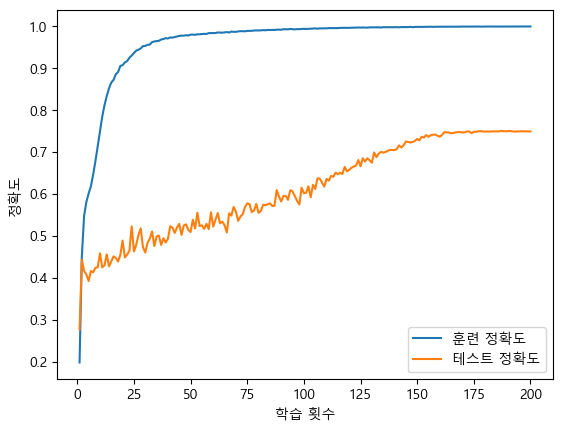

In [36]:
epochs = range(1, num_epochs+1)

plt.plot(epochs, train_acc_values, label='훈련 정확도')
plt.plot(epochs, test_acc_values, label='테스트 정확도')
plt.xlabel('학습 횟수')
plt.ylabel('정확도')
#plt.title('학습 데이터와 테스트 데이터 정확도 비교')
plt.legend()
plt.show()

In [37]:
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tokenizer, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=0)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("분노가")
            elif np.argmax(logits) == 1:
                test_eval.append("기쁨이")
            elif np.argmax(logits) == 2:
                test_eval.append("불안이")
            elif np.argmax(logits) == 3:
                test_eval.append("당황이")
            elif np.argmax(logits) == 4:
                test_eval.append("슬픔이")
            elif np.argmax(logits) == 5:
                test_eval.append("상처가")
            
            

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

In [39]:
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == "0" :
        break
    predict(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 한 대 쥐어박고 싶다
>> 입력하신 내용에서 분노가 느껴집니다.


하고싶은 말을 입력해주세요 : 한 대 때리고 싶다
>> 입력하신 내용에서 상처가 느껴집니다.


하고싶은 말을 입력해주세요 : 0
